In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [114]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load & Understand Data 

In [50]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [51]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [52]:
#double check shape
train.shape
test.shape #without SalePrice

(1460, 80)

(1459, 79)

In [53]:
train.isnull().sum().sort_values(ascending=False)[:11]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
dtype: int64

From head() & info() of dataset, we notice some important findings:
    1. Too many columns, dimension reduction is required later before throwing data into any model
    2. Several columns have missing values, needs to be filled or dropped based on further analysis
    3. several categorial columns need to be preprocessed and standarized

### Outlier

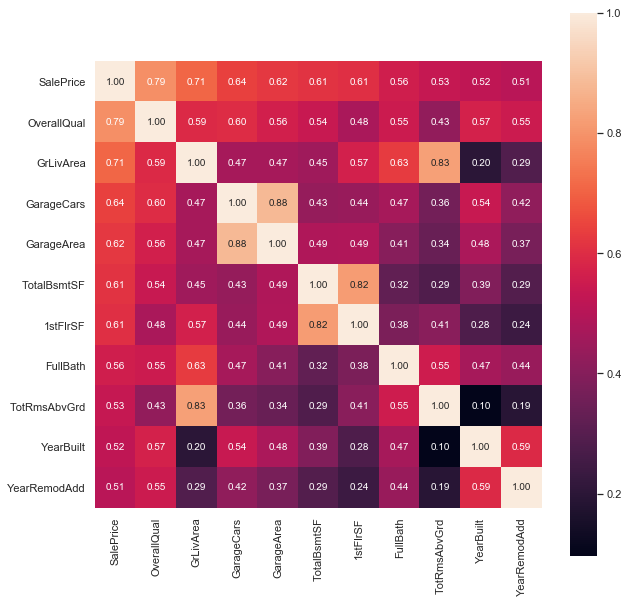

In [56]:
# Using heatmap to preview correlation importance between each column with 'SalePrice'
#which gives us the criteria of removing unrelated columns & let's only remain 20 columns 
k = 11 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)
plt.show()

From the heatmap above, we can find that:
    1. 'SalePrice' is highly correlated with 'OverallQual' & 'GrLivArea'
    2. 'GarageCars' is highly correlated with column 'GarageArea', so we could just choose the higher correlation coefficiency one: 'GarageCars'. Same idea applies to '1stFlrSF' & 'TotalBsmtSF', and we choose 'TotalBsmtSF'
    
To summarize:
    Columns I would use to analyze later would be 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd'

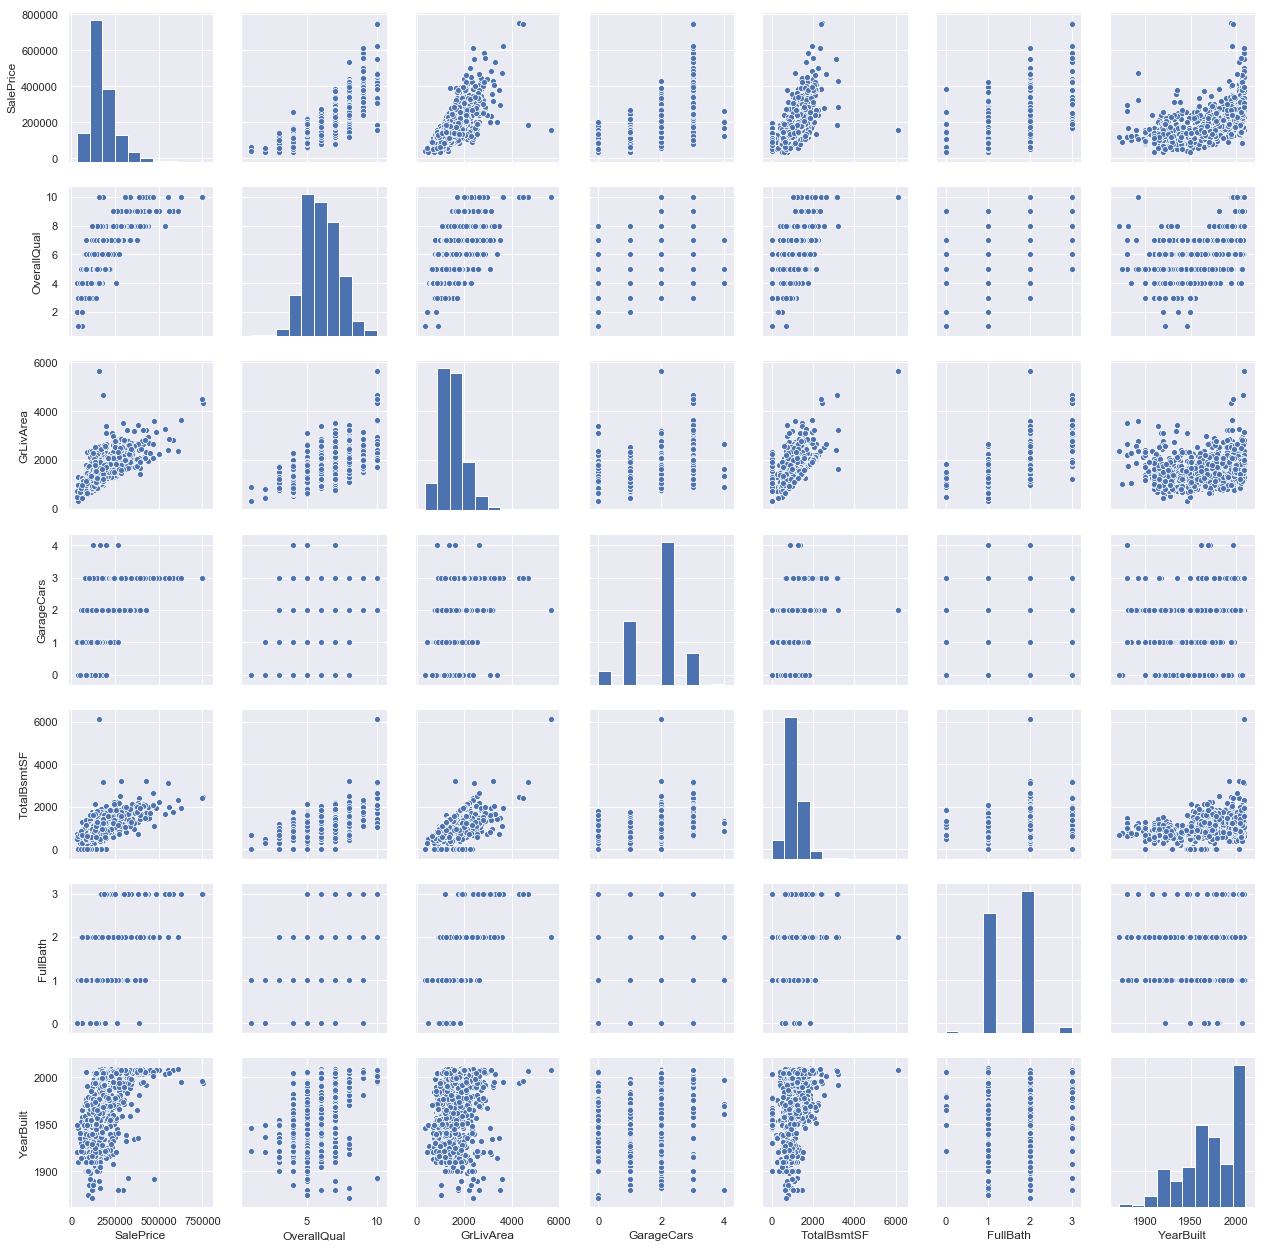

In [57]:
# Give overview before outlier tests

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

#### Univariate Analysis

In [58]:
# For univariate analysis, I usually would focus on my target value
# To confirm our observation on histogram of SalePrice above, here let's use 10 values on both tails 

#standardizing target value
saleprice_sca = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])
low_range = saleprice_sca[saleprice_sca[:,0].argsort()][:10]
high_range= saleprice_sca[saleprice_sca[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


From two tails value above, we can find:
    1. For low range value, 'SalesPrice' actually not really far away from 0
    2. For high range value, it's much higher away from 0 compared with low range, highly possible with outlier. To be confirmed in later test

#### Bivariate Analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


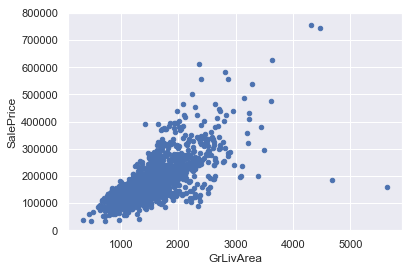

In [59]:
# For Bivariate Analysis, we would compare each column's performance with target value
# only applies with not too many features

# Based on pairplot above, two of them have obvious outliers: 'TotalBsmtSF' & 'GrLivArea'

# For 'GrLivArea':
#bivariate analysis saleprice/grlivarea
col1 = 'GrLivArea'
pd.concat([train['SalePrice'], train[col1]], axis=1).plot.scatter(x=col1, y='SalePrice', ylim=(0,800000));

In [60]:
# From graph above, I think the two points with 'GrLivArea' greater than 4000 are high leverage points
# Two points with 'SalePrices' greater than 700k are outliers, also confirmed the high range in univariate analysis

high_leverage_index=train.sort_values(by = 'GrLivArea', ascending = False)[:2].index
for label in high_leverage_index:
    train.drop(index=label, axis=1,inplace= True)

In [61]:
'''outlier_index1=train.sort_values(by = 'SalePrice', ascending = False)[:2].index
for value in outlier_index1:
    train.drop(index=value, axis=1,inplace= True)'''

"outlier_index1=train.sort_values(by = 'SalePrice', ascending = False)[:2].index\nfor value in outlier_index1:\n    train.drop(index=value, axis=1,inplace= True)"

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


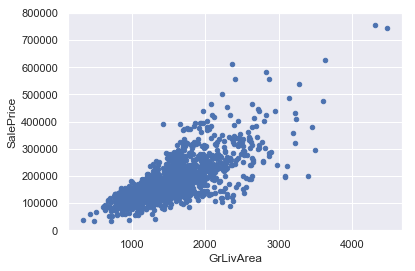

In [62]:
# Re-plot graph to double check
pd.concat([train['SalePrice'], train[col1]], axis=1).plot.scatter(x=col1, y='SalePrice', ylim=(0,800000));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


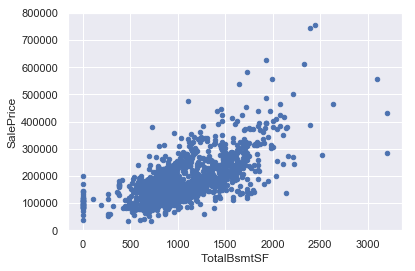

In [63]:
# For 'TotalBsmtSF':
#bivariate analysis saleprice/TotalBsmtSF
col2 = 'TotalBsmtSF'
pd.concat([train['SalePrice'], train[col2]], axis=1).plot.scatter(x=col2, y='SalePrice', ylim=(0,800000));

In [64]:
# From graph above, we can think three points with 'TotalBsmtSF' greater than 2800 are high leverage points
# The weird 'string' with values 'TotalBsmtSF'=0 are hard to tell, suggest keep it for now

high_leverage_TBSF=train.sort_values(by = 'TotalBsmtSF', ascending = False)[:3].index
for tbsf in high_leverage_TBSF:
    train.drop(index=tbsf, axis=1,inplace= True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


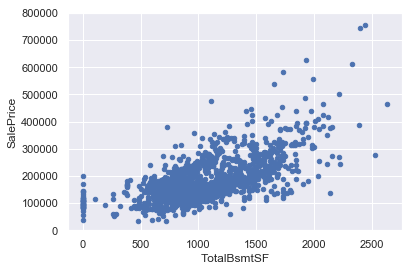

In [65]:
# Re-plot graph to double check
pd.concat([train['SalePrice'], train[col2]], axis=1).plot.scatter(x=col2, y='SalePrice', ylim=(0,800000));

#### Bivariate Summary
Since it's safe to remove outliers, however, with too many columns it would not be realistic to remove outliers from all columns and there are also outliers in test dataset, so recommend only check features highly correlated to target and in linearity features

#### Multivariate Analysis

There are four assumptions to be tested in this analysis:
    1. Normality
    2. Homoscedasticity 
    3. Linearity
    4. Absence of correlated errors:occurs often in time series, where patterns are time related. 
    
Since we have already checked the correlation between variables, No.4 not applicable here, let's do No.1-3

1. Normality

1.1 'SalePrice' column

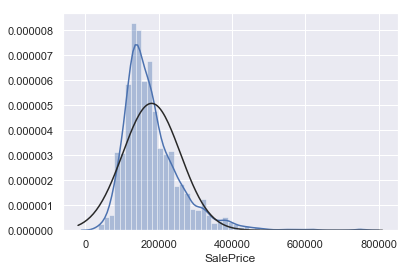

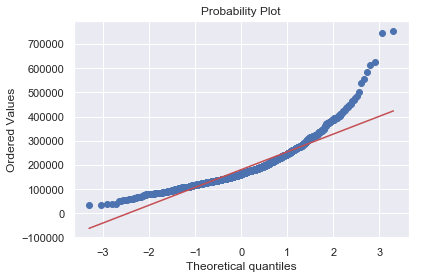

In [66]:
# In very first 'Load & Understand Data' section, we already know our target data is positively skewed
# To recall & confirm, we use Histogram & Normal probability plot to double check
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt);

In [67]:
# To solve positive skew problemwe, we would usually use log() transformation
train['SalePrice'] = np.log1p(train['SalePrice'])

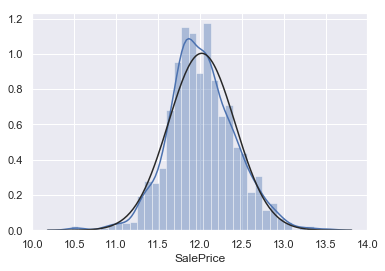

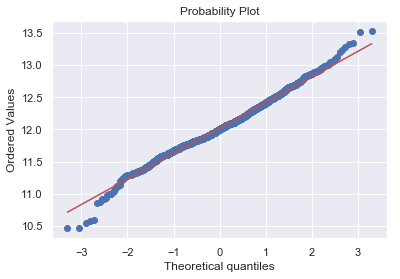

In [68]:
#double checked transformed histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt);

In [69]:
# From new graph, we can find there are still 5 outliers in the lower tail of salesprice
outlier_saleprices_more=train.sort_values(by = 'SalePrice', ascending = True)[:5].index
for index_ in outlier_saleprices_more:
    train.drop(index=index_, axis=1,inplace= True)

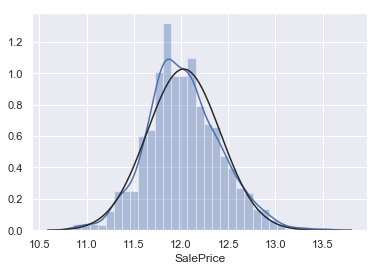

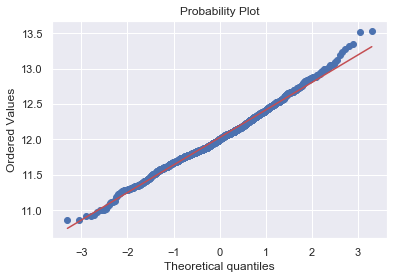

In [70]:
#triple checked transformed histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt);

1.2 'GrLivArea' Column

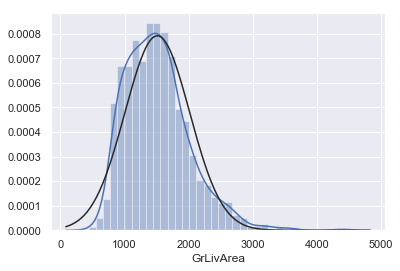

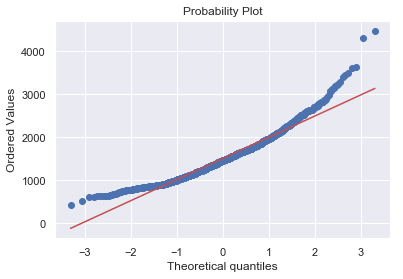

In [71]:
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt);

In [72]:
#From graph above, we find column 'GrLivArea' have same problem, and apply log() as well
train['GrLivArea'] = np.log1p(train['GrLivArea'])

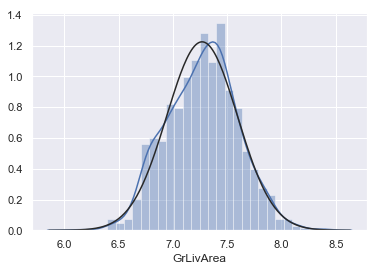

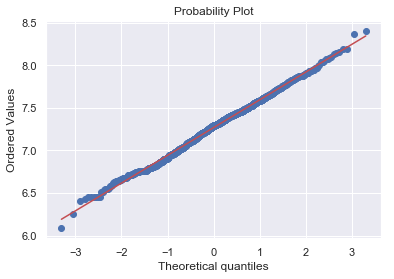

In [73]:
#double checked transformed histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt);

1.3 'TotalBsmtSF' Column

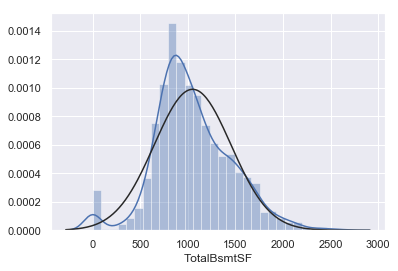

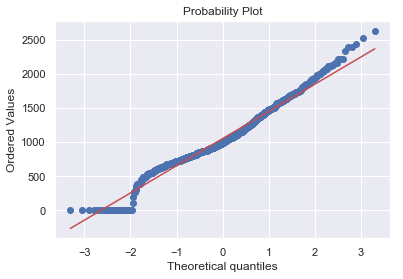

In [74]:
sns.distplot(train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt);

Let's check test data to see whether we should treat the 0 as outliers and removed

In [75]:
test['TotalBsmtSF'].isnull().sum()
test_copy=test.copy()
test_copy['TotalBsmtSF'].dropna(inplace=True)
test_copy['TotalBsmtSF'].isnull().sum()

1

0

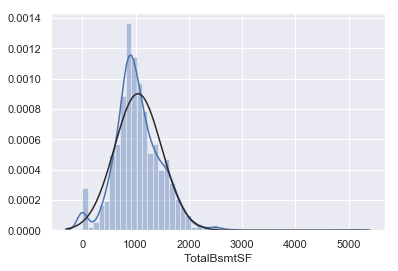

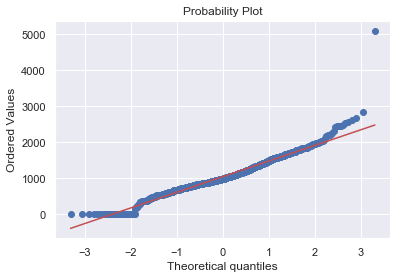

In [76]:
sns.distplot(test_copy['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(test_copy['TotalBsmtSF'], plot=plt);

As shown in the above graph, we can find that there are many 0 in testing dataset as well, so not recommend removing them here.

2. Homoscedasticity 

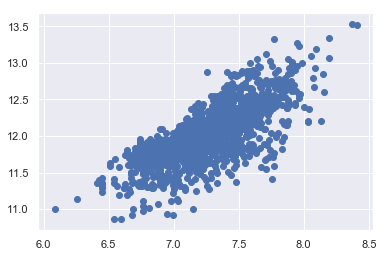

In [77]:
plt.scatter(train['GrLivArea'], train['SalePrice']);

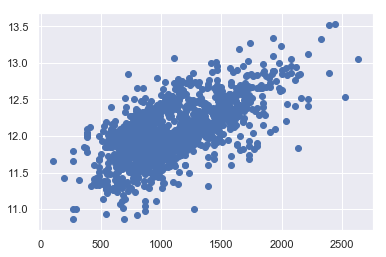

In [78]:
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);

Based on two graphs above, we can think they are almost in homoscedasticity situation, as for linearity, I think this can be easily viewed by pairplot in the beginning of this big section

### Feature Engineering

In [79]:
# let's concate both test and train together 
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2909, 79)


#### Missing Data

In [80]:
# check top 20 missing data columns in combined dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.690615
MiscFeature,96.390512
Alley,93.227913
Fence,80.474390
FireplaceQu,48.642145
LotFrontage,16.672396
GarageQual,5.362668
GarageCond,5.362668
GarageFinish,5.362668
GarageYrBlt,5.362668


#### Check overall correlation

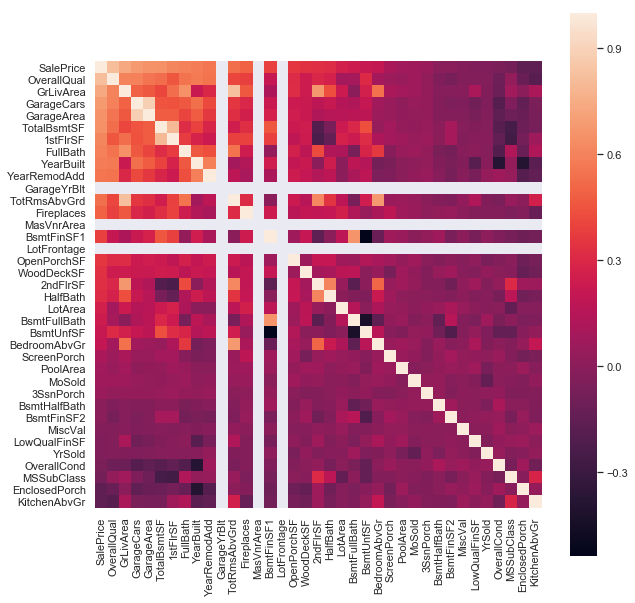

In [88]:
# list correlation based on importance
corrmat = train.corr()
cols = corrmat.nlargest(80, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
hm = sns.heatmap(cm, cbar=True, square=True, yticklabels=cols.values, xticklabels=cols.values, ax=ax)
plt.show()

#### Impute Missing Data

In [ ]:
# in the order of missing value ratio
# for PoolQC, MiscFeature, Alley, Fence, their ratio are over 80%, suggest dropping them

all_data.drop(columns={'PoolQC','MiscFeature','Alley','Fence'},inplace=True)
all_data.shape

In [92]:
#FireplaceQu
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [93]:
#LotFrontage:Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood 
#we can fill in missing values by the median LotFrontage of the neighborhood.
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [94]:
#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [95]:
#GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [96]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [97]:
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [98]:
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [99]:
#MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [100]:
#Utilities : For this categorical feature all records are "AllPub", 
#except for one "NoSeWa" and 2 NA . 
#Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

In [101]:
#Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [102]:
#Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [103]:
#KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [104]:
#Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [105]:
#SaleType : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [106]:
#MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [108]:
# Check any more missing value
all_data.isnull().sum().max() #double check no missing data anymore

0

#### Categorical Data Transformation

In [109]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

In [112]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [115]:
#Check skewed numerical features

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.909556
PoolArea,17.664161
LotArea,13.100491
LowQualFinSF,12.067635
3SsnPorch,11.356127
LandSlope,4.987862
KitchenAbvGr,4.293726
BsmtFinSF2,4.161505
EnclosedPorch,4.025690
ScreenPorch,3.949857


In [116]:
skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 56 skewed numerical features to Box Cox transform


In [117]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2909, 212)


In [118]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### Cross Validation & Modeling

In [134]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [126]:
#LASSO Regression :This model may be very sensitive to outliers. 
#So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [127]:
#base model score
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1090 (0.0105)



In [135]:
#Elastic Net Regression :again made robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [136]:
score_en = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_en.mean(), score_en.std()))

ElasticNet score: 0.1089 (0.0104)



In [128]:
#Gradient Boosting Regression : With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [130]:
score_bgr = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score_bgr.mean(), score_bgr.std()))

Gradient Boosting score: 0.1122 (0.0119)



In [131]:
#XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [132]:
score_xgb = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

Xgboost score: 0.1118 (0.0102)



In [145]:
n_folds = 5

def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = n_folds))
    return(rmse)

In [146]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [147]:
averaged_models = AveragingModels(models = (ENet, GBoost, model_xgb, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1052 (0.0108)



### Further Upgrade

#### Tune Hyperparameters

In [179]:
from sklearn.model_selection import RandomizedSearchCV
gbm_param_grid={
    'xgb_model__subsample':np.arange(.05,0.95,.05),
    'xgb_model__max_depth':np.arange(2,5,1),
    'xgb_model__n_estimators':np.arange(50,250,50),
    'xgb_model__colsample_bytree': np.arange(.1,1.05,.05),
    'xgb_model__learning_rate': np.arange(0.05,1.05,0.05)
}

In [180]:
# Initialize RandomizedSearchCV
randomized_neg_mse = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=gbm_param_grid, n_iter=10, scoring='neg_mean_squared_error',cv=5)

In [181]:
mse=randomized_neg_mse.fit(X_train.to_dict('records'), y_train)

In [182]:
print('Best RMSE:',np.sqrt(-mse.best_score_))

Best RMSE: 0.15014248611866965


In [183]:
print('Best Model:',mse.best_estimator_)

Best Model: Pipeline(memory=None,
     steps=[('ohe_onestep', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('xgb_model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9500000000000003, gamma=0, learning_rate=0.1,
       max_delta_step=0, ma...=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9000000000000001))])
